In [1]:
# guiduce, source code, structure, and details are provided by Yacine Jernite, https://yjernite.github.io/
# this notebook is implementation of his ideas in Linux and pytorch

##### This file need to be run in Linux

In [ ]:
#need to install
'''
elasticsearch
faiss_gpu --> need linux 
nlp
transformers
pytorch with cuda support
wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.7.1-linux-x86_64.tar.gz
tar -xzvf elasticsearch-7.7.1-linux-x86_64.tar.gz
'''

In [ ]:
import nlp
eli5 = nlp.load_dataset('eli5','rb') # explain like I'm 5 dataset

In [ ]:
import nlp
eli5 = nlp.load_dataset('eli5','rb') # explain like I'm 5 dataset
wiki40b_snippets = nlp.load_dataset('wiki_snippets', name='wiki40b_en_100_0')['train'] # and Wiki snippt

In [ ]:
# need python file lfqa_utils in the same folder
from lfqa_utils import *
# like dataloader for eli5, set upmodel, train model

In [ ]:
eli5['test_eli5'][12345] # q_id, title, subreddit, answers['a_id'], text, score

In [ ]:
# we will use wikipedia text
wiki40b_snippets[8991855]
# _id,nlp_id,wiki_id, start_paragraph, start_character, end_paragraph, end_character, article_title, section_title, passage_txt

# Retrive documents with ELI5-Trained Dense Model

### train a Bert like model for embedding Q&A and get documents from wiki

In [ ]:
#using bert to embedd questions and answers and brought demension down to 128, with 

# training arguments
class ArgumentsQAR():
    def __init__(self):
        self.batch_size = 512
        self.max_length = 128
        self.checkpoint_batch_size = 32
        self.print_freq = 100
        self.pretrained_model_name = "google/bert_uncased_L-8_H-768_A-12"
        self.model_save_name = "retriever_models/eli5_retriever_model_l-8_h-768_b-512-512"
        self.learning_rate = 2e-4
        self.num_epochs = 10

qar_args = ArgumentsQAR()

# prepare torch Dataset objects
qar_train_dset = ELI5DatasetQARetriver(eli5['train_eli5'], training=True)
qar_valid_dset = ELI5DatasetQARetriver(eli5['validation_eli5'], training=False)

# load pre-trained BERT and make model
qar_tokenizer, qar_model = make_qa_retriever_model(
        model_name=qar_args.pretrained_model_name,
        from_file=None,
        device="cuda:0"
)

# train the model
train_qa_retriever(qar_model, qar_tokenizer, qar_train_dset, qar_valid_dset, qar_args)

# this take me 5 hours omg...

### embedding all the records from the wikipedia snippets

In [ ]:
#create index for all the supportive documents in wiki
if not os.path.isfile('wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat'):
    make_qa_dense_index(
        qar_model, qar_tokenizer, wiki40b_snippets, device='cuda:0',
        index_name='wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat'
    )

# another 10 hours pass.

#  test to see if we can actually "generate" the correct reference for the questions

In [ ]:
faiss_res = faiss.StandardGpuResources()
wiki40b_passage_reps = np.memmap(
            'wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat',
            dtype='float32', mode='r',
            shape=(wiki40b_snippets.num_rows, 128)
)

wiki40b_index_flat = faiss.IndexFlatIP(128)
wiki40b_gpu_index = faiss.index_cpu_to_gpu(faiss_res, 1, wiki40b_index_flat)
wiki40b_gpu_index.add(wiki40b_passage_reps)

In [ ]:
# query methods for 
question = eli5['test_eli5'][12345]['title']
doc, res_list = query_qa_dense_index(question, qar_model, qar_tokenizer, wiki40b_snippets, wiki40b_gpu_index, device='cuda:1')

df = pd.DataFrame({
    'Article': ['---'] + [res['article_title'] for res in res_list],
    'Sections': ['---'] + [res['section_title'] if res['section_title'].strip() != '' else res['article_title']
                 for res in res_list],
    'Text': ['--- ' + question] + [res['passage_text'] for res in res_list],
})
df.style.set_properties(**{'text-align': 'left'})
# wola!!!the result will looks like this
# it's way better detailed explantions than the one retrieved from the sparse retrival method

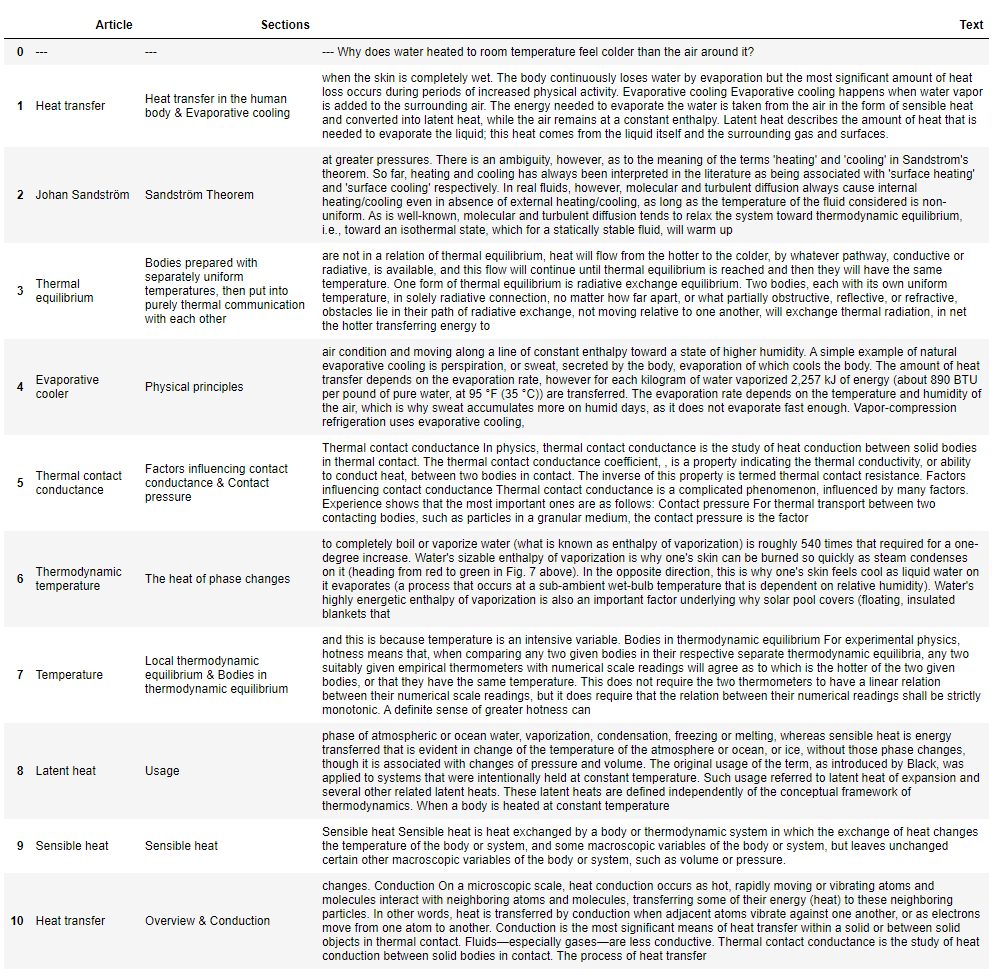

# evaluation part (in progress)

# Answer generation part

### we will use a sequence to sequence model like Bart architecture

In [ ]:
# pre-computing support documents
eli5_train_docs = []
for example in eli5['train_eli5']:
    support_doc, dense_res_list = query_qa_dense_index(
        example['title'], qar_model, qar_tokenizer, wiki40b_snippets, wiki40b_gpu_index, n_results=n_ret
    )
    eli5_train_docs += [(example['q_id'], support_doc, dense_res_list)]

eli5_valid_docs = []
for example in eli5['validation_eli5']:
    support_doc, dense_res_list = query_qa_dense_index(
        example['title'], qar_model, qar_tokenizer, wiki40b_snippets, wiki40b_gpu_index, n_results=n_ret
    )
    eli5_valid_docs += [(example['q_id'], support_doc, dense_res_list)]

# training loop proper
class ArgumentsS2S():
    def __init__(self):
        self.batch_size = 2
        self.backward_freq = 16
        self.max_length = 1024
        self.print_freq = 100
        self.model_save_name = "seq2seq_models/eli5_bart_model"
        self.learning_rate = 2e-4
        self.num_epochs = 3

s2s_args = ArgumentsS2S()

eli5_train_docs = json.load(open('precomputed/eli5_train_precomputed_dense_docs.json'))
eli5_valid_docs = json.load(open('precomputed/eli5_valid_precomputed_dense_docs.json'))
s2s_train_dset = ELI5DatasetS2S(eli5['train_eli5'], document_cache=dict([(k, d) for k, d, src_ls in eli5_train_docs]))
s2s_valid_dset = ELI5DatasetS2S(eli5['validation_eli5'], document_cache=dict([(k, d) for k, d, src_ls in eli5_valid_docs]), training=False)

qa_s2s_tokenizer, pre_model = make_qa_s2s_model(
    model_name="facebook/bart-large",
    from_file=None,
    device="cuda:0"
)
qa_s2s_model = torch.nn.Data(pre_model)

train_qa_s2s(qa_s2s_model, qa_s2s_tokenizer, s2s_train_dset, s2s_valid_dset, s2s_args)

# article said we need 18 hours for each, i willjust download the weights

In [ ]:
qa_s2s_tokenizer = AutoTokenizer.from_pretrained('yjernite/bart_eli5')
qa_s2s_model = AutoModelForSeq2SeqLM.from_pretrained('yjernite/bart_eli5').to('cuda:0')
_ = qa_s2s_model.eval() # i have to download the weights, or my gpu gonna run for a week

# test them on some records

In [ ]:
questions = []
answers = []

for i in [12345] + [j for j in range(4)]:
    # create support document with the dense index
    question = eli5['test_eli5'][i]['title']
    doc, res_list = query_qa_dense_index(
        question, qar_model, qar_tokenizer,
        wiki40b_snippets, wiki40b_gpu_index, device='cuda:1'
    )
    # concatenate question and support document into BART input
    question_doc = "question: {} context: {}".format(question, doc)
    # generate an answer with beam search
    answer = qa_s2s_generate(
            question_doc, qa_s2s_model, qa_s2s_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]
    questions += [question]
    answers += [answer]

df = pd.DataFrame({
    'Question': questions,
    'Answer': answers,
})
df.style.set_properties(**{'text-align': 'left'})

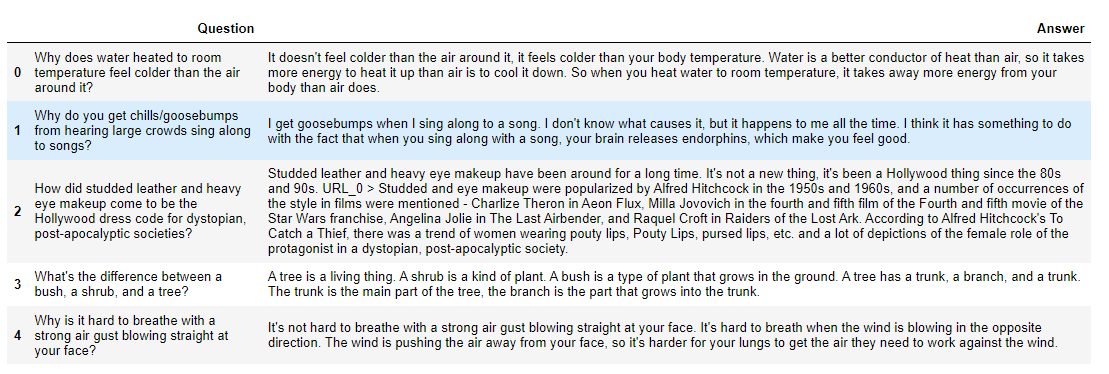

# Evaluation part (in process)

In [ ]:
#nice!